<a href="https://colab.research.google.com/github/flyconnectome/imagereg_workshop/blob/main/notebooks/generate_image_volumes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generating the synapse density images for registration

### Requirements

For this tutorial we will need:
- `fw_synapse_points.feather` (49Mb): the FLYWIRE synapse cloud (30x subsampled)
- `mcns_synapse_points.feather` (64Mb): t-bars for the entire male CNS (10x subsampled)
- `pandas`, `numpy`, `matplotlib`, `pynrrd`, `scipy`

In [1]:
!wget https://flyem.mrc-lmb.cam.ac.uk/flyconnectome/imagereg_workshop/mcns_synapse_points.feather
!wget https://flyem.mrc-lmb.cam.ac.uk/flyconnectome/imagereg_workshop/fw_synapse_points.feather

--2025-12-04 10:39:24--  https://flyem.mrc-lmb.cam.ac.uk/flyconnectome/imagereg_workshop/mcns_synapse_points.feather
Resolving flyem.mrc-lmb.cam.ac.uk (flyem.mrc-lmb.cam.ac.uk)... 131.111.85.46
Connecting to flyem.mrc-lmb.cam.ac.uk (flyem.mrc-lmb.cam.ac.uk)|131.111.85.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62967466 (60M) [application/octet-stream]
Saving to: ‘mcns_synapse_points.feather’

mcns_synapse_points 100%[===================>]  60.05M  18.9MB/s    in 3.2s    

2025-12-04 10:39:28 (18.9 MB/s) - ‘mcns_synapse_points.feather’ saved [62967466/62967466]

--2025-12-04 10:39:28--  https://flyem.mrc-lmb.cam.ac.uk/flyconnectome/imagereg_workshop/fw_synapse_points.feather
Resolving flyem.mrc-lmb.cam.ac.uk (flyem.mrc-lmb.cam.ac.uk)... 131.111.85.46
Connecting to flyem.mrc-lmb.cam.ac.uk (flyem.mrc-lmb.cam.ac.uk)|131.111.85.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49024914 (47M) [application/octet-stream]
Saving to: ‘

In [2]:
!pip install pandas numpy pynrrd matplotlib scipy

In [3]:
import nrrd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import ndimage

In [4]:
# Load the male CNS t-bars data (this is 8x8x8nm)
points_mcns = pd.read_feather("mcns_synapse_points.feather")

# Convert to microns
points_mcns = points_mcns[["x", "y", "z"]].values / 125

# Convert to 1x1x1um resolution pixels
points_mcns = (points_mcns // 1).astype(int)

# Create a 3D histogram
mx = points_mcns.max(axis=0) + 1
img_mcns = np.histogramdd(
    points_mcns, bins=[np.arange(mx[0] + 1), np.arange(mx[1] + 1), np.arange(mx[2] + 1)]
)[0]

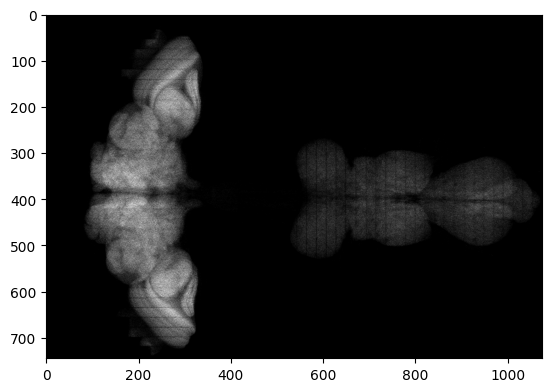

In [5]:
# Top view projection
plt.imshow(img_mcns.sum(axis=1), cmap="gray")

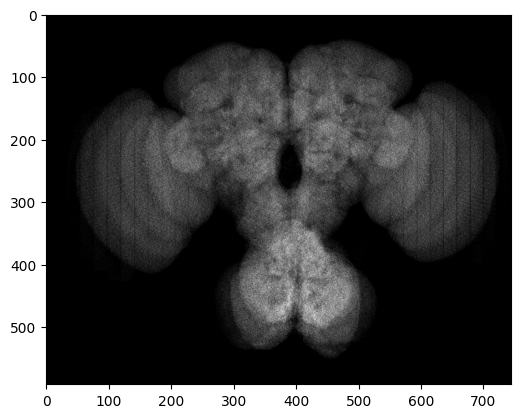

In [6]:
# Frontal view projection
plt.imshow(img_mcns.sum(axis=2).T, cmap="gray")

To make our lives a bit easier, we will remove the VNC part of the volume

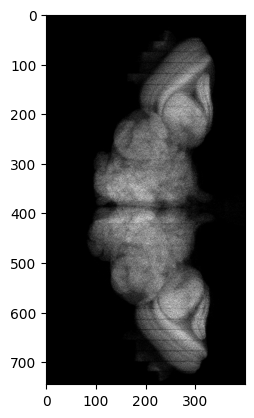

In [7]:
# Trim image to just the brain (and remove some ventral space)
img_mcns_brain = img_mcns[:, :450, :400]

plt.imshow(img_mcns_brain.sum(axis=1), cmap="gray")

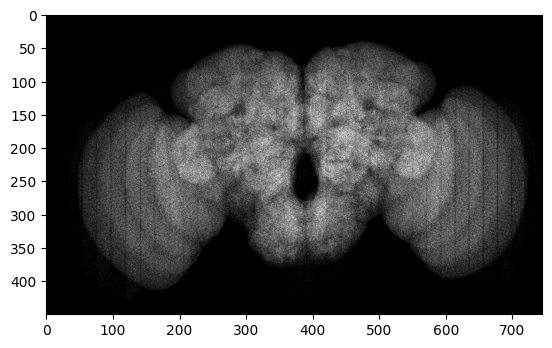

In [8]:
plt.imshow(img_mcns_brain.sum(axis=2).T, cmap="gray")

Next we will apply some gaussian smoothing

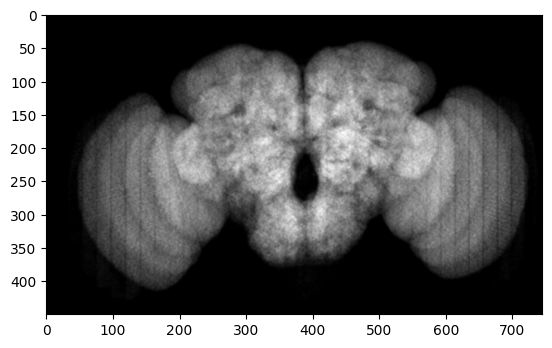

In [9]:
# Smooth
img_mcns_brain_smooth = ndimage.gaussian_filter(img_mcns_brain, sigma=1)

# Normalize (note that we normalize to 99th percentile to avoid outliers)
img_mcns_brain_smooth = np.clip(
    img_mcns_brain_smooth / np.percentile(img_mcns_brain_smooth, 99) * 255, 0, 255
).astype(np.uint8)

plt.imshow(img_mcns_brain_smooth.sum(axis=2).T, cmap="gray")

In [10]:
# Write out the NRRD file
nrrd.write("mcns_synapse_volume_brain.nrrd", img_mcns_brain_smooth)

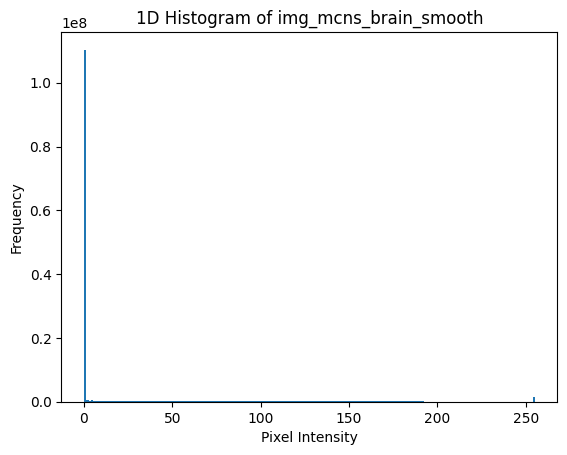

In [11]:
plt.hist(img_mcns_brain_smooth.flatten(), bins=256)
plt.title('1D Histogram of img_mcns_brain_smooth')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

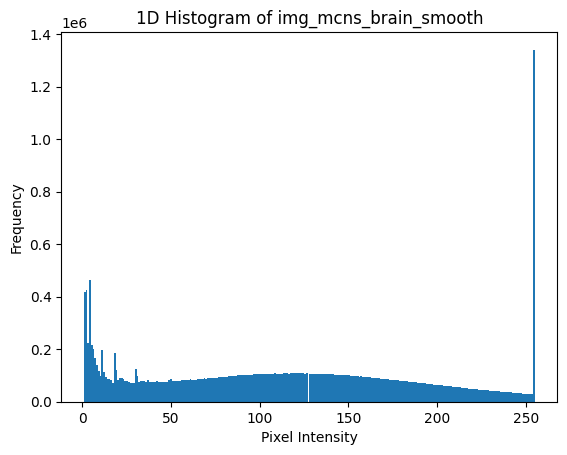

In [14]:
non_zero_values = img_mcns_brain_smooth[img_mcns_brain_smooth != 0]
plt.hist(non_zero_values.flatten(), bins=256)
plt.title('1D Histogram of img_mcns_brain_smooth')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

In the code above, `img_mcns_brain_smooth != 0` creates a boolean mask where `True` indicates a non-zero value and `False` indicates a zero value. When you use this mask to index `img_mcns_brain_smooth`, it returns a 1D array containing only the values where the mask is `True` (i.e., the non-zero values).

Now we will do the same for the FlyWire synapse cloud

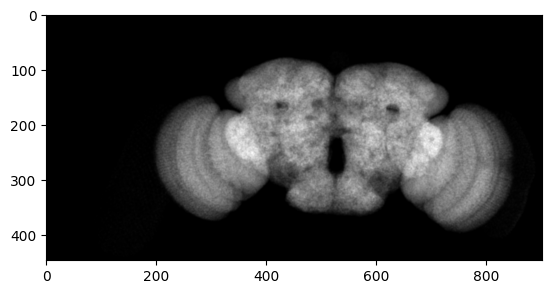

In [15]:
# This data is in nm resolution
points_fw = pd.read_feather(
    "fw_synapse_points.feather",
).values

# # Convert to 1x1x1um resolution voxels
points_fw = (points_fw // 1000).astype(int)

# # Create a 3D histogram
mx = points_fw.max(axis=0) + 1
img_fw = np.histogramdd(
    points_fw, bins=[np.arange(mx[0] + 1), np.arange(mx[1] + 1), np.arange(mx[2] + 1)]
)[0]

# Smooth
img_fw_smooth = ndimage.gaussian_filter(img_fw, sigma=1)

# Normalize (note that we normalize to 99th percentile to avoid outliers)
img_fw_smooth = np.clip(
    img_fw_smooth / np.percentile(img_fw_smooth, 99) * 255, 0, 255
).astype(np.uint8)

# Write out the NRRD file
nrrd.write("fw_synapse_volume.nrrd", img_fw_smooth)

# Plot frontal view
plt.imshow(img_fw_smooth.sum(axis=2).T, cmap="gray")

Now download the two `.nrrd` files to your local machine!